#  Analyse spectra ADR holo at AuxTel for Configuration PSF1D REBIN = 2

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- 
- creation date : June 27th  2022
- last update : June 27th 2022

- **kernel anaconda3_auxtel** at CC or **python 3** locally


## ANalyse ADR subtraction

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

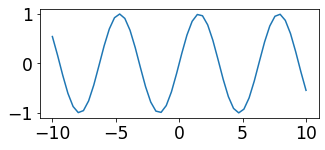

In [3]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [4]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [5]:
from datetime import datetime,date

In [6]:
#pip install fpdf
#from fpdf import FPDF

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [7]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [8]:
string_date

'2022-07-08'

In [9]:
from iminuit import Minuit
import iminuit

In [10]:
iminuit.__version__

'2.8.4'

In [11]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor, dumpParameters, FullForwardModelFitWorkspace,  run_ffm_minimisation, plot_comparison_truth
from spectractor.extractor.spectrum import Spectrum, detect_lines
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d

from spectractor.simulation.adr import adr_calib, flip_and_rotate_adr_to_image_xy_coordinates

In [12]:
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

In [13]:
from time import sleep

In [14]:
from astropy.time import Time
import astropy.units as u

In [15]:
import pickle

# Function

In [16]:
def file_tag_forsorting(filename):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('^exposure_.*([0-9][0-9][0-9][0-9][0-9])_postisrccd.*', filename)
    if len(m)>0:
        return m[0]
    else:
        return None


In [17]:
def subdir_tag_forsorting(subdir):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('.*([0-9][0-9][0-9][0-9][0-9])$', subdir)
    if len(m)>0:
        return m[0]
    else:
        return None


In [18]:
file_tag_forsorting('exposure_2022031600330_postisrccd.fits')

'00330'

In [19]:
subdir_tag_forsorting('2022031600330')

'00330'

# Config

In [20]:
# path index for each month
DATE="20220317"
#DATE="20211104"
filterdispersername = "empty~holo4_003"
#filterdispersername = "BG40~holo4_003"
imagemode = "postISRCCD"
#imagemode = "unflattened"

In [21]:
version="v5.0"

In [22]:
# Choose the config filename
list_of_spectractorconfigfiles= ['auxtel_config_holo_DECONVOLUTION_PSF1D.ini' ,
                                 'auxtel_config_holo_DECONVOLUTION_PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_FFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF2DFFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotA.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotB.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotC.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotD.ini']
                                 
                                 
config_idx = 4
configfilename= os.path.join("./config",list_of_spectractorconfigfiles[config_idx])
#configdir = (list_of_spectractorconfigfiles[config_idx].split("_")[-1]).split(".") [0]
configdir = "config_" + (list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_")[-1]).split(".") [0]

In [23]:
configdir 

'config_DECONVOLUTION_REBIN2PSF1D'

In [24]:
load_config(configfilename)

In [25]:
parameters.LAMBDA_MAX=700
parameters.LAMBDA_MIN=300

In [26]:
dumpParameters()

ASTROMETRYNET_DIR 
BGD_ORDER 1
CALIB_BGD_NPARAMS 4
CALIB_BGD_ORDER 3
CALIB_BGD_WIDTH 15
CALIB_PEAK_WIDTH 7
CALIB_SAVGOL_ORDER 2
CALIB_SAVGOL_WINDOW 5
CCD_ARCSEC2RADIANS 4.84813681109536e-06
CCD_GAIN 1.1
CCD_IMSIZE 2048
CCD_MAXADU 170000
CCD_PIXEL2ARCSEC 0.1904
CCD_PIXEL2MM 0.02
CCD_REBIN 2
CONFIG_DIR /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/../config/
DEBUG False
DEBUG_LOGGING False
DISPERSER_DIR /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/
DISPLAY False
DISTANCE2CCD 175
DISTANCE2CCD_ERR 0.75
FGB37 {'label': 'FGB37', 'min': 350, 'max': 750}
FILTERS [{'label': 'RG715', 'min': 690, 'max': 1100}, {'label': 'FGB37', 'min': 350, 'max': 750}, {'label': 'Halfa', 'min': 0.0006431, 'max': 0.0006686999999999999}, {'label': 'Z-Gunn', 'min': 800, 'max': 1100}]
FLAM_TO_ADURATE 5175865186660.421
GRATING_ORDER_2OVER1 0.1
GROOVES_PER_MM 350
HAL

In [27]:
configmode = list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_DECONVOLUTION_")[-1].split(".") [0]
configmode

'REBIN2PSF1D'

# Path

In [28]:
HOSTCC=True

In [29]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
    if configdir == "":
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
    else:
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
        path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
        path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
        path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)

else:
    path_auxtel="/Users/sylvie/DATA/AuxTelData2022"
    path_spectractor=os.path.join(path_auxtel,"/Users/sylvie/MacOSX/GitHub/LSST/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
    if configdir == "":
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
    else:
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
        path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
        path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
        path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)


In [30]:
path_output_spectractor

'/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_REBIN2PSF1D/20220317'

In [31]:
! ls -l $path_output_spectractor

total 0
drwxrws--- 1 dagoret lsst 2 Jun 28 14:36 2022031700237


In [32]:
# standard configuration for spectractor
#config = os.path.join(path_spectractor_config,"auxtel.ini")
#config=os.path.join("./config",configfilename)
config=configfilename
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : ./config/auxtel_config_holo_DECONVOLUTION_REBIN2PSF1D.ini


In [33]:
load_config(configfilename)

## Logbook for file selection

In [34]:
filename_logbook='logbooks/auxtellogbook_'+filterdispersername+"_"+DATE+'_' + version+'.csv'

In [35]:
df=pd.read_csv(filename_logbook,index_col=0)

In [36]:
pd.set_option('display.max_rows', None)

In [37]:
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2022-03-18T00:51:03.112,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031700237_postisrccd.fits,237,mu. col,empty_1,holo4_003,1.114069,20.0,...,8.9,48.0,9.4,NaN,NaN,NaN,NaN,,NaN,NaN
1,1,2022-03-18T00:51:36.190,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031700238_postisrccd.fits,238,mu. col,empty_1,holo4_003,1.115188,20.0,...,8.9,48.0,9.4,NaN,NaN,NaN,NaN,,NaN,NaN
2,2,2022-03-18T00:54:30.463,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031700244_postisrccd.fits,244,mu. col,empty_1,holo4_003,1.121178,20.0,...,8.9,49.0,8.7,NaN,NaN,NaN,NaN,,NaN,NaN
3,3,2022-03-18T00:55:03.377,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031700245_postisrccd.fits,245,mu. col,empty_1,holo4_003,1.122325,20.0,...,8.8,49.0,7.5,NaN,NaN,NaN,NaN,,NaN,NaN
4,4,2022-03-18T00:58:01.707,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031700251_postisrccd.fits,251,mu. col,empty_1,holo4_003,1.128693,20.0,...,8.9,50.0,10.2,NaN,NaN,NaN,NaN,,NaN,NaN
5,5,2022-03-18T00:58:34.835,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031700252_postisrccd.fits,252,mu. col,empty_1,holo4_003,1.129892,20.0,...,8.9,50.0,10.2,NaN,NaN,NaN,NaN,,NaN,NaN
6,6,2022-03-18T01:01:32.859,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031700258_postisrccd.fits,258,mu. col,empty_1,holo4_003,1.136492,20.0,...,8.9,53.0,10.1,NaN,NaN,NaN,NaN,,NaN,NaN
7,7,2022-03-18T01:02:05.775,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031700259_postisrccd.fits,259,mu. col,empty_1,holo4_003,1.137732,20.0,...,8.9,52.0,10.4,NaN,NaN,NaN,NaN,,NaN,NaN
8,8,2022-03-18T01:05:03.839,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031700265_postisrccd.fits,265,mu. col,empty_1,holo4_003,1.144579,20.0,...,8.9,53.0,10.5,NaN,NaN,NaN,NaN,,NaN,NaN
9,9,2022-03-18T01:05:36.766,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031700266_postisrccd.fits,266,mu. col,empty_1,holo4_003,1.145874,20.0,...,8.9,53.0,10.5,NaN,NaN,NaN,NaN,,NaN,NaN


## Selection of input files

In [38]:
# Do not consider flag
#df_good=df[df["quality"]==1]

In [39]:
df_good=df
df_good["quality"] = 1

In [40]:
for spectra_file in df_good["file"]:
    print(spectra_file)

exposure_2022031700237_postisrccd.fits
exposure_2022031700238_postisrccd.fits
exposure_2022031700244_postisrccd.fits
exposure_2022031700245_postisrccd.fits
exposure_2022031700251_postisrccd.fits
exposure_2022031700252_postisrccd.fits
exposure_2022031700258_postisrccd.fits
exposure_2022031700259_postisrccd.fits
exposure_2022031700265_postisrccd.fits
exposure_2022031700266_postisrccd.fits
exposure_2022031700272_postisrccd.fits
exposure_2022031700273_postisrccd.fits
exposure_2022031700279_postisrccd.fits
exposure_2022031700280_postisrccd.fits
exposure_2022031700286_postisrccd.fits
exposure_2022031700287_postisrccd.fits
exposure_2022031700293_postisrccd.fits
exposure_2022031700294_postisrccd.fits
exposure_2022031700300_postisrccd.fits
exposure_2022031700301_postisrccd.fits
exposure_2022031700309_postisrccd.fits
exposure_2022031700310_postisrccd.fits
exposure_2022031700316_postisrccd.fits
exposure_2022031700317_postisrccd.fits
exposure_2022031700323_postisrccd.fits
exposure_2022031700324_po

## Selection of Spectractor output files

In [41]:
# total number of exposures
NBEXP=0
# total number of exposures without dir
NBEXPNODIR=0
# total number of exposures with dir
NBEXPWTHDIR=0
# total number of exposures with plots
NBEXPWTHPLT=0
# total number of exposures with spectra
NBEXPWTHSPEC=0

# list of exposures
LISTNUM=[]
# list of exposure without dir (not run spectraction)
LISTNUMNODIR=[]
# list of exposure with dir (spectraction has been run)
LISTNUMWTHDIR=[]
# list of exposures with plots (Spectractor has run up to some point)
LISTNUMWTHPLOTS=[]
# list of exposures with spectraction output (Spectractor has completed)
LISTNUMWTHSPECTR=[]

# list of selected spectra path
List_of_spectra_path=[]

In [42]:
list_of_files=os.listdir(path_output_spectractor)
list_of_files=sorted(list_of_files)


print("list of subdir found ",list_of_files)

for subdir in list_of_files:
    
    
    #tag = file_tag_forsorting(subdir)
    tag = subdir_tag_forsorting(subdir)
    
        
    print(tag)    
    #if tag is not None and int(tag)<317:
    #    continue
    if tag is None :
        continue
  
    
    
    fulldir=os.path.join(path_output_spectractor,subdir)



    if not os.path.isdir(fulldir):
        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is not a directory".format(subdir))
        

        NBEXPNODIR+=1


    else:

        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is a directory".format(subdir))

        tagname=subdir_tag_forsorting(subdir)
        print("tagname= {}".format(tagname))
        #targetname=file_target(subdir)
        #print("targetname= {}".format(targetname))
        



        NBEXP += 1
        LISTNUM.append(tagname)



        dir_plots=os.path.join(fulldir,"plots")
        dir_spectration = os.path.join(fulldir, "basespec")

        flag_empty1 = True
        flag_empty2 = True


        if os.path.isdir(dir_plots):
            if any(os.scandir(dir_plots)):
                print("dir_plots is not empty")
                NBEXPWTHPLT+=1
                LISTNUMWTHPLOTS.append(tagname)
                flag_empty1 = False

            else:
                print("dir_plots is empty")


        if os.path.isdir(dir_spectration):
            if any(os.scandir(dir_spectration)):
                print("dir_spectration is not empty")
                NBEXPWTHSPEC+=1
                LISTNUMWTHSPECTR.append(tagname)
                flag_empty2 = False
                List_of_spectra_path.append(dir_spectration)

            else:
                print("dir_spectration is empty")

        if flag_empty1 and flag_empty2 :
            NBEXPNODIR+=1
            LISTNUMNODIR.append(tagname)
        else:
            NBEXPWTHDIR += 1
            LISTNUMWTHDIR.append(tagname)



print("-----------------------------------------------------------------")


#LISTNUM=sorted(LISTNUM)
#LISTNUMNODIR=sorted(LISTNUMNODIR)
#LISTNUMWTHDIR=sorted(LISTNUMWTHDIR)
#LISTNUMWTHPLOTS=sorted(LISTNUMWTHPLOTS)
#LISTNUMWTHSPECTR=sorted(LISTNUMWTHSPECTR)
List_of_spectra_path=sorted(List_of_spectra_path)

print("Full list of Exposures : .......................{}".format(LISTNUM))
print("Full list of Exposures without output dir: .....{}".format(LISTNUMNODIR))
print("Full list of Exposures with output dir: ....... {}".format(LISTNUMWTHDIR))
print("Full list of Exposures with output plots: ..... {}".format(LISTNUMWTHPLOTS))
print("Full list of Exposures with output spectra: ....{}".format(LISTNUMWTHSPECTR))




print("Total number of exposures : .....................{}".format(NBEXP))
print("Total number of exposures without dir : .........{}".format(NBEXPNODIR))
print("Total number of exposures with dir :.............{}".format(NBEXPWTHDIR))
print("Total number of exposures with plots : ..........{}".format(NBEXPWTHPLT))
print("Total number of exposures with spectra: .........{}".format(NBEXPWTHSPEC))


list of subdir found  ['2022031700237']
00237
---------------------------------------------
2022031700237  	   00237
2022031700237 is a directory
tagname= 00237
dir_plots is not empty
dir_spectration is not empty
-----------------------------------------------------------------
Full list of Exposures : .......................['00237']
Full list of Exposures without output dir: .....[]
Full list of Exposures with output dir: ....... ['00237']
Full list of Exposures with output plots: ..... ['00237']
Full list of Exposures with output spectra: ....['00237']
Total number of exposures : .....................1
Total number of exposures without dir : .........0
Total number of exposures with dir :.............1
Total number of exposures with plots : ..........1
Total number of exposures with spectra: .........1


In [43]:
#dir_spectra="outputs_reprocess"
print(List_of_spectra_path)

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_REBIN2PSF1D/20220317/2022031700237/basespec']


In [44]:
config

'./config/auxtel_config_holo_DECONVOLUTION_REBIN2PSF1D.ini'

## Extraction of spectra

In [45]:
all_files_spectra = []
all_files_spectrogram = []
all_files_lines = []
all_files_table = []

# loop on topdir
for dir_spectra in List_of_spectra_path:
    for filename in os.listdir(dir_spectra):
        if re.search("_spectrum.fits$",filename):
            the_file_spectrum=os.path.join(dir_spectra,filename)
            all_files_spectra.append(the_file_spectrum)
            the_file_spectrogram=the_file_spectrum.replace("_spectrum","_spectrogram")
            all_files_spectrogram.append(the_file_spectrogram)
            the_file_lines=the_file_spectrum.replace("_spectrum.fits","_lines.csv")
            all_files_lines.append(the_file_lines)
            the_file_table=the_file_spectrum.replace("_spectrum.fits","_table.csv")
            all_files_table.append(the_file_table)
    

In [46]:
all_files_spectra[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_REBIN2PSF1D/20220317/2022031700237/basespec/exposure_2022031700237_postisrccd_spectrum.fits']

In [47]:
all_files_spectrogram[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_REBIN2PSF1D/20220317/2022031700237/basespec/exposure_2022031700237_postisrccd_spectrogram.fits']

In [48]:
all_files_lines[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_REBIN2PSF1D/20220317/2022031700237/basespec/exposure_2022031700237_postisrccd_lines.csv']

In [49]:
all_files_table[:3] 

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_REBIN2PSF1D/20220317/2022031700237/basespec/exposure_2022031700237_postisrccd_table.csv']

## Selection of good spectra

In [50]:
all_good_spectra_spectrum_files = sorted(all_files_spectra)

In [51]:
N=len(all_good_spectra_spectrum_files)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

## All Spectra

In [52]:
all_num=[]
idx=0
for fullfilename in all_good_spectra_spectrum_files:
    filename= os.path.basename(fullfilename)
    tag=file_tag_forsorting(filename.split(".")[0])
    all_num.append(tag)
    idx+=1
    
    

In [53]:
if False:
    parameters.DISPLAY=True

    FLAG_ORDER2 = True

    infos = []
    all_lambdas=[]
    all_data=[]
    all_data_err=[]

    if FLAG_ORDER2:
        all_lambdas_order2=[]
        all_data_order2=[]
        all_data_err_order2=[]

    all_num=[]
    all_figs = []


    idx=0
    for fullfilename in all_good_spectra_spectrum_files:
    
        filename = os.path.basename(fullfilename)
        print(idx,")",filename," ",fullfilename)
    
    
        fig=plt.figure(figsize=(16,4))
        ax1 = fig.add_subplot(1, 2, 1)
    
        filename= os.path.basename(fullfilename)
        tag=file_tag_forsorting(filename.split(".")[0])
        all_num.append(tag)
    
   
     
        s=Spectrum(fullfilename, config=config,fast_load=False)
        label=filename.split('.')[0]+" "
        s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
        all_lambdas.append(s.lambdas)
        all_data.append(s.data)
        all_data_err.append(s.err)
    
        if FLAG_ORDER2:
            all_lambdas_order2.append(s.lambdas_order2)
            all_data_order2.append(s.data_order2)
            all_data_err_order2.append(s.err_order2)
    
        ax2 = fig.add_subplot(1, 2, 2)
    
        fullfilename2=all_files_spectrogram[idx]
    
        s.load_spectrogram(fullfilename2)
        s.plot_spectrogram(ax=ax2,scale="log")
    
    
        infos.append([idx,s.target.label,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
    
    
        plt.show()
        all_figs.append(fig)
    
        idx+=1
    

## View one spectrum

0 ) exposure_2022031700237_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_REBIN2PSF1D/20220317/2022031700237/basespec/exposure_2022031700237_postisrccd_spectrum.fits


2022-07-08 11:33:55  astropy    _showwarning         WARNING AstropyDeprecationWarning: The update_default_config function is deprecated and may be removed in a future version.


set date_obs to 2022-03-18T00:50:48.964
set expo to 20.0
set airmass to 1.11445296512311
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to -0.28
set dec to -32.3064444444444
set hour_angle to 30.73762446363224
set temperature to 8.9
set pressure to 743.45
set humidity to 48.0
set lambda_ref to 631.9145079684116
set parallactic_angle to 93.74272252137011


2022-07-08 11:33:55  astropy    _showwarning         WARNING AstropyDeprecationWarning: "pedantic" was deprecated in version 5.0 and will be removed in a future version. Use argument "verify" instead.


target_name = mu.col, Selected object name for Simbad : mu. Col
 MAIN_ID        RA           DEC      ...  Z_VALUE  SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                           
--------- ------------- ------------- ... --------- ----------------
* mu. Col 05 45 59.8950 -32 18 23.162 ... 0.0003640                1


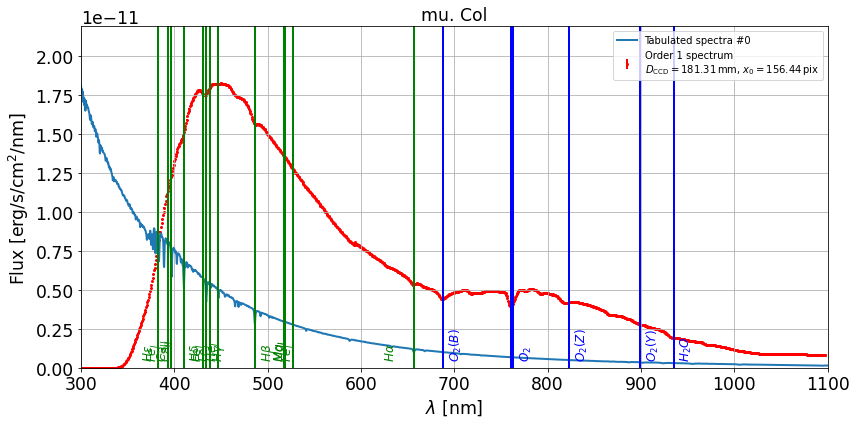

In [54]:
idx=0

fullfilename = all_good_spectra_spectrum_files[idx]
    
filename = os.path.basename(fullfilename)
print(idx,")",filename," ",fullfilename)
    
    
fig=plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 1, 1)
    
filename= os.path.basename(fullfilename)
tag=file_tag_forsorting(filename.split(".")[0])
all_num.append(tag)
    
   
     
s=Spectrum(fullfilename, config=config,fast_load=False)
label=filename.split('.')[0]+" "
#s.plot_spectrum(ax=ax1,force_lines=True,label=label)
s.plot_spectrum(ax=ax1,force_lines=True)
    
    
#ax2 = fig.add_subplot(1, 2, 2)
    
#fullfilename2=all_files_spectrogram[idx]
    
#s.load_spectrogram(fullfilename2)
#s.plot_spectrogram(ax=ax2,scale="log")
    

plt.show()
    

In [55]:
from spectractor.simulation.adr import adr_calib, flip_and_rotate_adr_to_image_xy_coordinates

In [56]:
fig_FFMpoutputdir = "fig_FFM_" + configdir
if not os.path.exists(fig_FFMpoutputdir):
        os.makedirs(fig_FFMpoutputdir)

In [57]:
parameters.DISPLAY = True
parameters.DEBUG = True
parameters.VERBOSE = True
parameters.LSST_SAVEFIGPATH = fig_FFMpoutputdir

In [58]:
# Want to plot some information
# if 'LBDAS_T' in spec.header: plot_comparison_truth(spec, w)
s.header['LBDAS_T'] = True

In [59]:
w = FullForwardModelFitWorkspace(s, verbose=parameters.VERBOSE, plot=True, live_fit=True,
                                         amplitude_priors_method="spectrum")

2022-07-08 11:33:59  FullForwardModelFitWorkspace __init__             INFO   
	Full forward model fitting with regularisation parameter r=1.


In [60]:
# increase the nulber of iteration
#spectrum = run_ffm_minimisation(w, method="newton", niter=5)

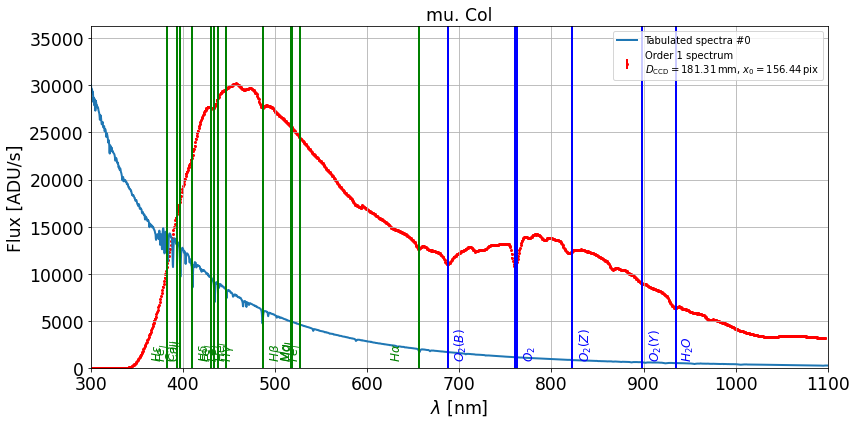

In [61]:
s.plot_spectrum(force_lines=True) 

In [62]:
s.lambdas

array([ 299.35687638,  300.06184611,  300.7668051 , ..., 1096.20734382,
       1096.88423511, 1097.56108901])

In [63]:
s.data_order2

array([0., 0., 0., ..., 0., 0., 0.])

Text(0.5, 1.0, 'Order 2')

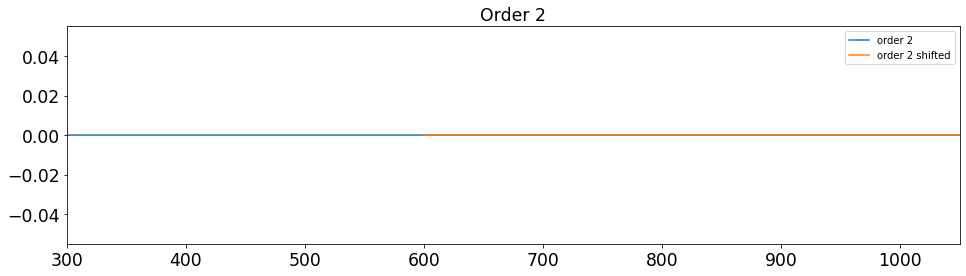

In [64]:
plt.plot(s.lambdas,s.data_order2,label="order 2")
plt.plot(2*s.lambdas,s.data_order2/2,label="order 2 shifted")
plt.xlim(300,1050)
plt.legend()
plt.title("Order 2")

Text(0.5, 1.0, 'Order 1')

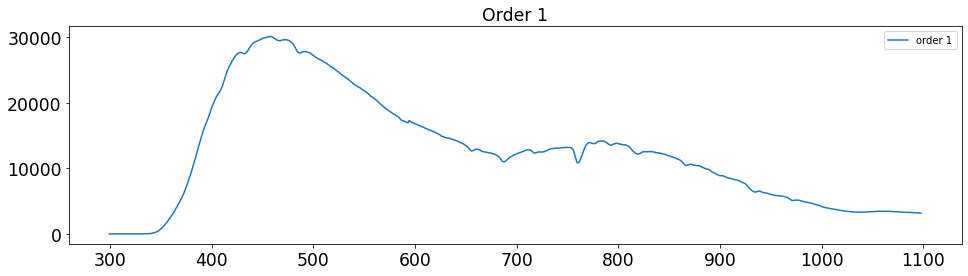

In [65]:
plt.plot(s.lambdas,s.data,label="order 1")
plt.legend()
plt.title("Order 1")

# Simulation of ADR

In [66]:
def showfitparameter(w):
    N1= len(w.input_labels) 
    N2 = len(w.p)
    assert N1 == N2
    
    for idx in range(N1):
        tag=w.input_labels[idx]
        val=w.p[idx]
        print(f"{idx} :: {tag} = {val}")

In [67]:
def gettemperature(w):
    return w.p[8]

In [68]:
def getpressure(w):
    return w.p[7]

In [69]:
def settemperature(w,T):
    w.p[8]=T

In [70]:
def setpressure(w,P):
    w.p[7]=P

In [71]:
showfitparameter(w)

0 :: A2 = 1.0
1 :: D_CCD [mm] = 181.312826436761
2 :: shift_x [pix] = -0.1511882604364546
3 :: shift_y [pix] = 0.0
4 :: angle [deg] = -0.28
5 :: B = 1.0
6 :: R = 0.0
7 :: P [hPa] = 743.45
8 :: T [Celsius] = 8.9
9 :: x_c_0 = 999.1189912121253
10 :: x_c_1 = 575.4931279665329
11 :: x_c_2 = 0.0
12 :: y_c_0 = 3.574947098802857
13 :: y_c_1 = 2.73771583866332
14 :: y_c_2 = -0.7069567876125603
15 :: gamma_0 = 6.178185558626659
16 :: gamma_1 = -1.5628450840965327
17 :: gamma_2 = 1.4731948252661538
18 :: alpha_0 = 1.8102056359892473
19 :: alpha_1 = -0.3970153722375538
20 :: alpha_2 = 0.2548527865367822
21 :: saturation_0 = 8499.687172396581


## example of simulation

2022-07-08 11:34:07  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure fig_FFM_config_DECONVOLUTION_REBIN2PSF1D/ffm_bestfit.pdf.
2022-07-08 11:34:09  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure fig_FFM_config_DECONVOLUTION_REBIN2PSF1D/ffm_bestfit_2.pdf.


Text(0.5, 1.0, 'Before optimization')

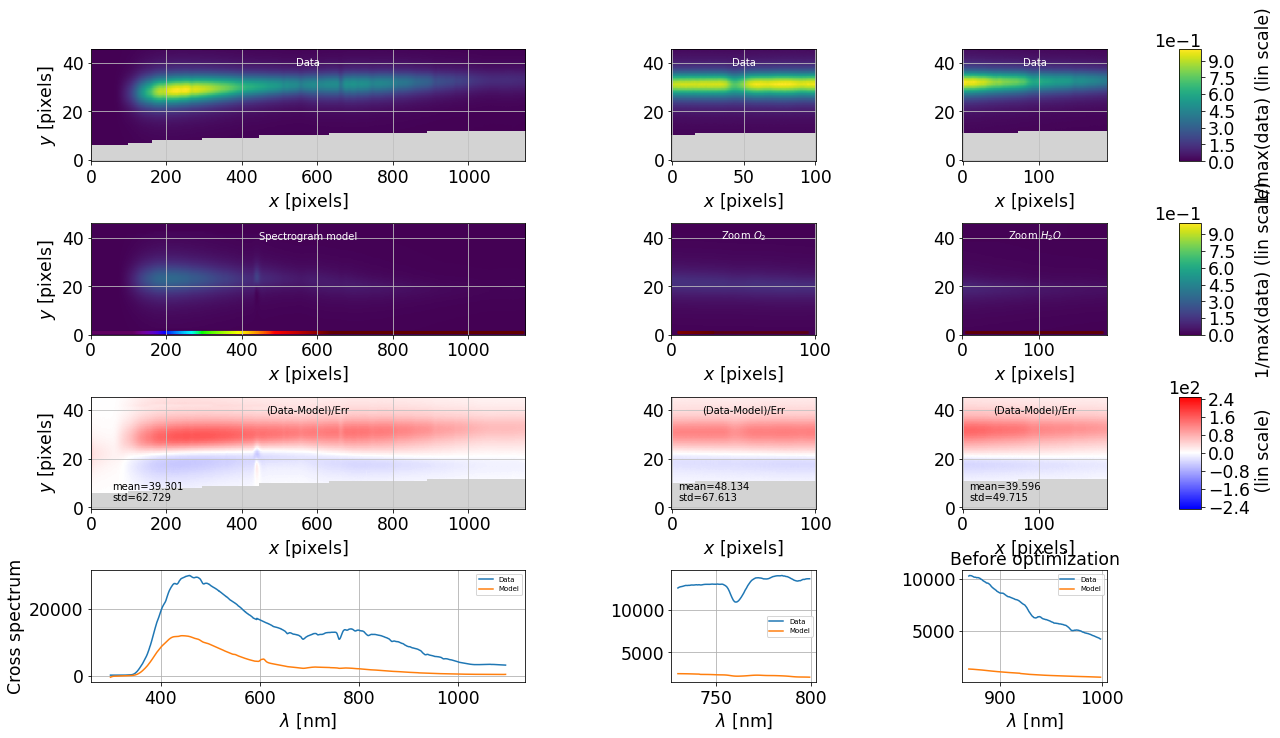

In [72]:
y, mod, mod_err = w.simulate(*w.p)
w.plot_fit()
plt.gca().set_title("Before optimization")

## Optimization 

In [73]:
# increase the nulber of iteration
# spectrum = run_ffm_minimisation(w, method="newton", niter=1)

In [74]:
showfitparameter(w)

0 :: A2 = 1.0
1 :: D_CCD [mm] = 181.312826436761
2 :: shift_x [pix] = -0.1511882604364546
3 :: shift_y [pix] = 0.0
4 :: angle [deg] = -0.28
5 :: B = 1.0
6 :: R = 0.0
7 :: P [hPa] = 743.45
8 :: T [Celsius] = 8.9
9 :: x_c_0 = 999.1189912121253
10 :: x_c_1 = 575.4931279665329
11 :: x_c_2 = 0.0
12 :: y_c_0 = 3.574947098802857
13 :: y_c_1 = 2.73771583866332
14 :: y_c_2 = -0.7069567876125603
15 :: gamma_0 = 6.178185558626659
16 :: gamma_1 = -1.5628450840965327
17 :: gamma_2 = 1.4731948252661538
18 :: alpha_0 = 1.8102056359892473
19 :: alpha_1 = -0.3970153722375538
20 :: alpha_2 = 0.2548527865367822
21 :: saturation_0 = 8499.687172396581


In [114]:
all_temperatures = np.arange(-100,11,10)

In [100]:
NT = len(all_temperatures)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NT)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NT), alpha=1)

In [143]:
def plotmyadrorder1(w,P0):

    fig = plt.figure(figsize=(18,3))
    ax=fig.add_subplot(1,1,1)
    for idx, T in enumerate(all_temperatures):
  
        # decode parameters
        A2, D2CCD, dx0, dy0, angle, B, rot, pressure, temperature, *poly_params = w.p
    
        profile_params = w.spectrum.chromatic_psf.from_poly_params_to_profile_params(poly_params, apply_bounds=True)
        profile_params[:, 0] = 1
        profile_params[:, 1] = np.arange(w.Nx)
    
    
        new_s = w.spectrum
    
        new_s.adr_params[2] = T
        new_s.adr_params[3] = P0
        adr_ra, adr_dec = adr_calib(new_s.lambdas, new_s.adr_params, parameters.OBS_LATITUDE,lambda_ref=new_s.lambda_ref)
        adr_x, adr_y = flip_and_rotate_adr_to_image_xy_coordinates(adr_ra, adr_dec, dispersion_axis_angle=0)
    
    
        # Distance in x and y with respect to the true order 0 position at lambda_ref
        Dx = np.arange(w.Nx) - w.spectrum.spectrogram_x0 - dx0  # distance in (x,y) spectrogram frame for column x
        Dy_disp_axis = np.tan(angle * np.pi / 180) * Dx  # disp axis height in spectrogram frame for x
    
    
        profile_params[:, 1] = Dx + w.spectrum.spectrogram_x0 + adr_x + dx0
        profile_params[:, 2] = Dy_disp_axis + (w.spectrum.spectrogram_y0 + adr_y + dy0) - w.bgd_width
        labeltag = f" T = {T} °C "
        ax.plot(profile_params[:, 1],profile_params[:, 2],color=all_colors[idx], label=labeltag)
    
        plt.legend()
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        title=f" ADR order 1 with pressure = {P0} hPa"
        ax.set_title(title)
        ax.set_xlabel("X (pix)")
        ax.set_ylabel("Y (pix)")
    

In [154]:
# Evaluate ADR for order 2
def plotmyadrorder2(w,P0):

    fig = plt.figure(figsize=(18,3))
    ax=fig.add_subplot(1,1,1)
    for idx, T in enumerate(all_temperatures):
        
        # decode parameters
        A2, D2CCD, dx0, dy0, angle, B, rot, pressure, temperature, *poly_params = w.p
    
        profile_params = w.spectrum.chromatic_psf.from_poly_params_to_profile_params(poly_params, apply_bounds=True)
        profile_params[:, 0] = 1
        profile_params[:, 1] = np.arange(w.Nx)
    
    
        new_s = w.spectrum
    
        new_s.adr_params[2] = T
        new_s.adr_params[3] = P0
        
  
        adr_ra, adr_dec = adr_calib(new_s.lambdas_order2, new_s.adr_params, parameters.OBS_LATITUDE,
                                    lambda_ref=w.spectrum.lambda_ref)
        adr_x_2, adr_y_2 = flip_and_rotate_adr_to_image_xy_coordinates(adr_ra, adr_dec, dispersion_axis_angle=0)
        # adr_u_2, adr_v_2 = flip_and_rotate_adr_to_image_xy_coordinates(adr_ra, adr_dec, dispersion_axis_angle=angle)
        # Compute lambdas at pixel column x for order 2
        # self.lambdas_order2 = self.spectrum.disperser.grating_pixel_to_lambda(distance - adr_u_2,
        #                                                                    self.spectrum.x0 + np.asarray([dx0, dy0]),
        #                                                                    order=2)

        # Fill spectrogram trace as a function of the pixel column x
        profile_params[:, 1] = Dx + w.spectrum.spectrogram_x0 + adr_x + dx0
        profile_params[:, 2] = Dy_disp_axis + (w.spectrum.spectrogram_y0 + adr_y + dy0) - w.bgd_width
        # Dy_disp_axis = np.copy(profile_params[:, 2])
        # profile_params[:, 2] += adr_y + dy0 - self.bgd_width
        
        profile_params_order2 = np.copy(profile_params)
        profile_params_order2[:, 0] = w.spectrum.disperser.ratio_order_2over1(w.lambdas)
        profile_params_order2[:, 1] = np.arange(w.Nx) + adr_x_2 + dx0
        profile_params_order2[:, 2] = Dy_disp_axis + (w.spectrum.spectrogram_y0 + adr_y_2 + dy0) - w.bgd_width
        
        labeltag = f" T = {T} °C "
        ax.plot(profile_params_order2[:, 1],profile_params_order2[:, 2],color=all_colors[idx], label=labeltag)
    
        plt.legend()
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        title=f" ADR order 2 with pressure = {P0} hPa"
        ax.set_title(title)
        ax.set_xlabel("X (pix)")
        ax.set_ylabel("Y (pix)")
    
        
        

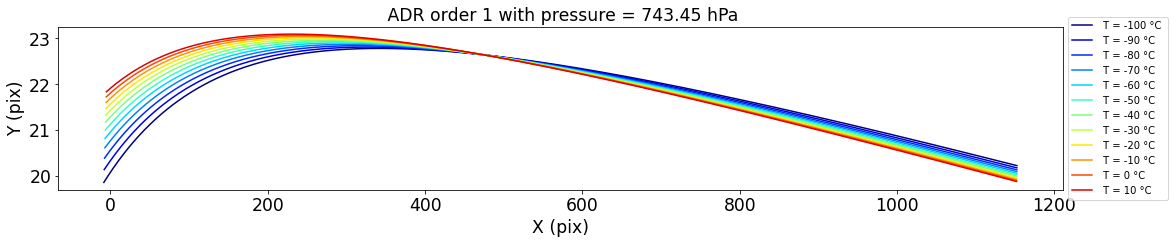

In [145]:
P0 = 743.45
plotmyadrorder1(w,P0)

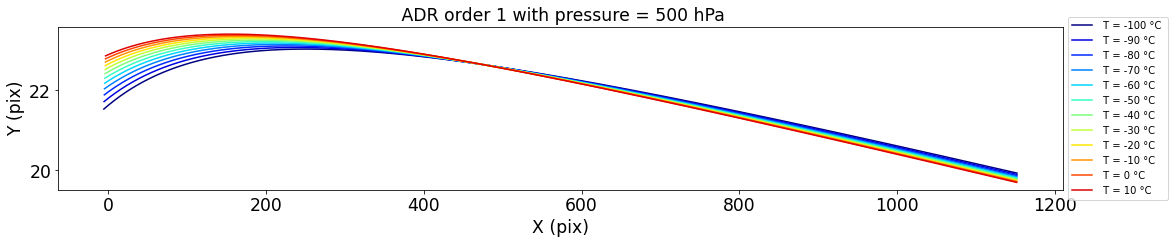

In [146]:
P0 = 500
plotmyadrorder1(w,P0)